In [ ]:
import os,cv2,keras 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf



In [ ]:
"""
kết nối với drive của mình
"""
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Deep Learning/Object Detection/Data/image_car.zip

In [ ]:
!unzip image_car.zip

In [ ]:
"""
bộ dữ liệu
"""
import cv2
train_path = "/content/drive/MyDrive/Deep Learning/Object Detection/Data/New folder (2)"
label = pd.read_csv("/content/drive/MyDrive/Deep Learning/Object Detection/Data/train_solution_bounding_boxes (1).csv") 

In [ ]:
fnames = [os.path.join(train_path,fname) for fname in os.listdir(train_path)]

In [ ]:
train_data = [cv2.imread(fname) for fname in fnames] ## danh sach anh

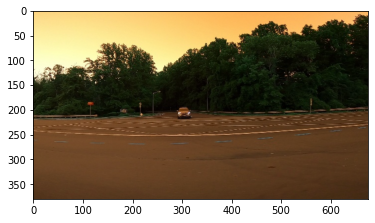

In [ ]:
plt.imshow(train_data[0])

In [ ]:
fnames = os.listdir(train_path) ## danh sach ten anh

In [ ]:
fnames[0]

'vid_4_1000.jpg'

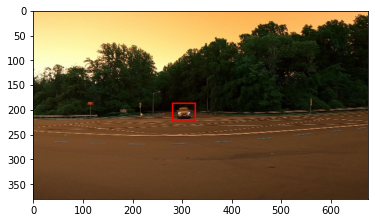

In [ ]:
img = train_data[0]
row = label[label['image'] == fnames[0]]
x1 = int(row['xmin'])
y1 = int(row['ymin'])
x2 = int(row['xmax'])
y2 = int(row['ymax'])
cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
plt.imshow(img)

1106


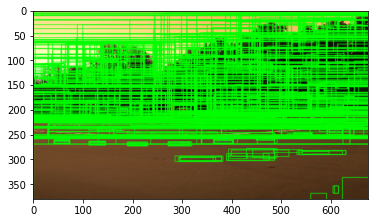

In [ ]:
## tim kiem cac vung tiem nang bang thuat toan Selection Search ( ussing cv2)
## vi du
test_image = train_data[0]
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(test_image)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = test_image.copy()
region_count = 0
for i,rect in (enumerate(rects)):
  x,y,w,h = rect 
  region_count +=1
  cv2.rectangle(imOut,(x,y),(x+w,y+h),(0,255,0),1,cv2.LINE_AA)
plt.imshow(imOut)
print(region_count)


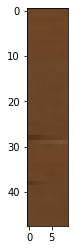

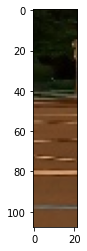

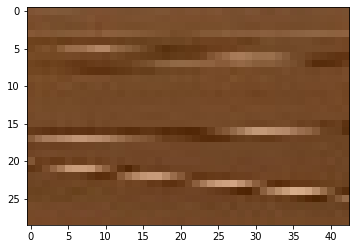

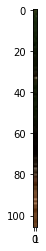

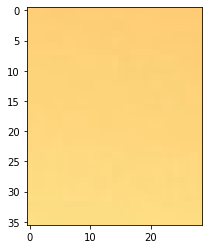

In [ ]:
#show 1 so region 
a = 0
for i,rect in (enumerate(rects)):
  x,y,w,h = rect
  if(x+w<=test_image.shape[0] and y+h <= test_image.shape[1]):
    plt.imshow(test_image[x:x+w,y:y+h])
    plt.show()
    a+=1
  if(a==5):
    break



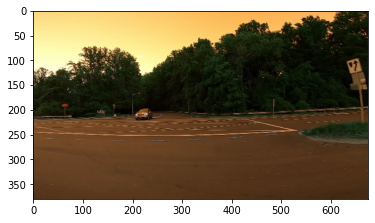

In [ ]:
plt.imshow(train_data[1])

In [ ]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
train_image = []
train_label = []

In [ ]:
for i in range(len(train_data)):
  df = label[label['image'] == fnames[i]]
  gtvalues=[]
  for row in df.iterrows():
      x1 = int(row[1]['xmin'])
      y1 = int(row[1]['ymin'])
      x2 = int(row[1]['xmax'])
      y2 = int(row[1]['ymax'])
      gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
  ss.setBaseImage(train_data[i])
  ss.switchToSelectiveSearchFast()
  ssresults = ss.process()
  imout = train_data[i].copy()
  counter = 0
  flag = 0
  falsecount = 0
  fflag = 0
  bflag = 0
  for e,result in enumerate(ssresults):
    if e<2000 and flag ==0:
        for gtval in gtvalues:
          x,y,w,h = result
          iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
          if counter < 30:
            if (iou > 0.7):
              timage = imout[y:y+h,x:x+w]
              resized = cv2.resize(timage,(224,224),interpolation = cv2.INTER_AREA)
              train_image.append(resized)
              train_label.append(1)
              counter +=1
          else:
            flag = 1
          if falsecount < 30:
            if iou <0.3:
              timage = imout[y:y+h,x:x+w]
              resized = cv2.resize(timage,(224,224),interpolation = cv2.INTER_AREA)
              train_image.append(resized)
              train_label.append(0)
              falsecount +=1
          else:
            bflag = 1
        if fflag ==1 and bflag ==1:
          flag = 1

In [ ]:
len(train_image)

1983

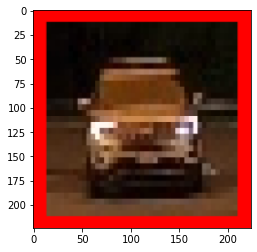

In [ ]:
plt.imshow(train_image[25])

In [ ]:
train_label[25]

1

In [ ]:
X_new = np.array(train_image)
y_new = np.array(train_label)

In [ ]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [ ]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

In [ ]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

In [ ]:
X= vggmodel.layers[-2].output

In [ ]:
predictions = Dense(2, activation="softmax")(X)

In [ ]:
model_final = Model(inputs=vggmodel.input,outputs = predictions)

In [ ]:
from keras.optimizers import Adam
opt = Adam(lr=0.0001)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

In [ ]:
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [ ]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [ ]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [ ]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [ ]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [ ]:
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 2, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])


<ipython-input-229-af9b79a3d645>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 2, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])


Epoch 1/2
10/10 [==============================] - ETA: 0s - loss: 0.0394 - accuracy: 0.9812 
Epoch 1: val_loss improved from 0.19069 to 0.08486, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 314s 32s/step - loss: 0.0394 - accuracy: 0.9812 - val_loss: 0.0849 - val_accuracy: 0.9688
Epoch 2/2
10/10 [==============================] - ETA: 0s - loss: 0.0955 - accuracy: 0.9750 
Epoch 2: val_loss did not improve from 0.08486
10/10 [==============================] - 273s 27s/step - loss: 0.0955 - accuracy: 0.9750 - val_loss: 0.4052 - val_accuracy: 0.9531


1/1 [==============================] - 1s 1s/step
not car


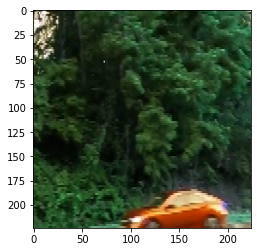

In [ ]:
im = X_test[115]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("car")
else:
    print("not car")

In [ ]:
test_path = "/content/drive/MyDrive/Deep Learning/Object Detection/Data/test_car"

In [ ]:
fnames = [os.path.join(test_path,fname) for fname in os.listdir(test_path)]

In [ ]:
test_data = [cv2.imread(fname) for fname in fnames]

1/1 [==============================] - 1s 613ms/step


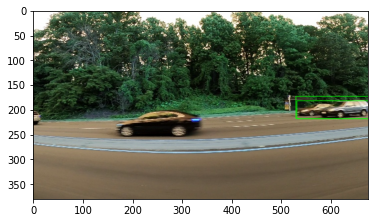

In [ ]:
img = test_data[0]
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()
imout = img.copy()
for e,result in enumerate(ssresults):
    if e < 300:
      x,y,w,h = result
      timage = imout[y:y+h,x:x+w]
      resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
      img = np.expand_dims(resized, axis=0)
      out= model_final.predict(img)
    if out[0][0] > 0.65:
      cv2.rectangle(imout, (x, y), (x+w, y+h  ), (0, 255, 0), 1, cv2.LINE_AA)
plt.imshow(imout)
plt.show()

In [ ]:
import selectivesearch

ModuleNotFoundError: ignored